##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

## Setup / Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Data/data')

## Download and explore the dataset

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


## Load data

### Create a dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "train",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 44 files belonging to 2 classes.
Using 36 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "validation",
  validation_split=0.5,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8 files belonging to 2 classes.
Using 4 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['mosquito', 'tick']


## Visualize the data

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.2392157 0.98666364


### Create the model

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 45, 45, 64)      

### Train the model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2/2 [==============================] - 3s 467ms/step - loss: 0.8184 - accuracy: 0.4722 - val_loss: 0.6732 - val_accuracy: 0.7500
Epoch 2/10
2/2 [==============================] - 0s 19ms/step - loss: 0.6938 - accuracy: 0.6667 - val_loss: 0.9059 - val_accuracy: 0.2500
Epoch 3/10
2/2 [==============================] - 0s 18ms/step - loss: 0.7885 - accuracy: 0.4722 - val_loss: 0.6360 - val_accuracy: 0.7500
Epoch 4/10
2/2 [==============================] - 0s 31ms/step - loss: 0.6978 - accuracy: 0.5556 - val_loss: 0.6419 - val_accuracy: 0.7500
Epoch 5/10
2/2 [==============================] - 0s 32ms/step - loss: 0.6631 - accuracy: 0.5556 - val_loss: 0.6566 - val_accuracy: 0.7500
Epoch 6/10
2/2 [==============================] - 0s 18ms/step - loss: 0.6482 - accuracy: 0.6667 - val_loss: 0.6968 - val_accuracy: 0.7500
Epoch 7/10
2/2 [==============================] - 0s 20ms/step - loss: 0.6296 - accuracy: 0.6667 - val_loss: 0.6612 - val_accuracy: 0.7500
Epoch 8/10
2/2 [==========

## Visualize training results

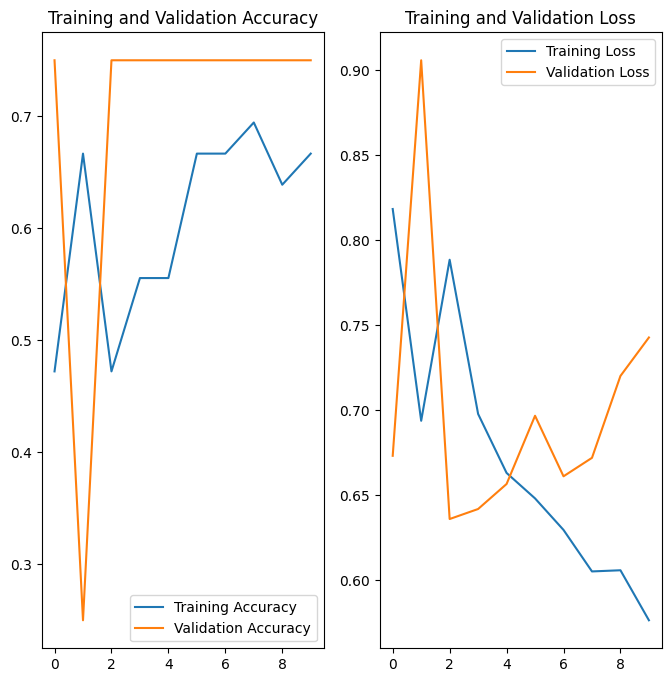

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Aug Visual

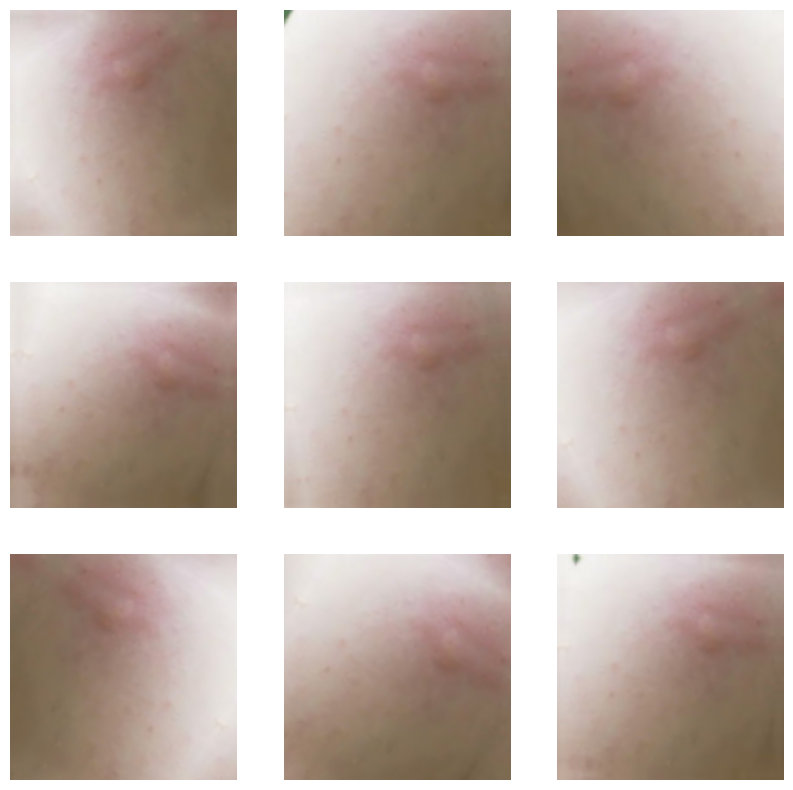

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_19 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
2/2 [==============================] - 0s 38ms/step - loss: 0.4506 - accuracy: 0.8056 - val_loss: 0.9366 - val_accuracy: 0.7500
Epoch 2/20
2/2 [==============================] - 0s 26ms/step - loss: 0.7647 - accuracy: 0.7222 - val_loss: 0.5474 - val_accuracy: 0.7500
Epoch 3/20
2/2 [==============================] - 0s 23ms/step - loss: 0.4703 - accuracy: 0.7778 - val_loss: 0.4969 - val_accuracy: 0.7500
Epoch 4/20
2/2 [==============================] - 0s 49ms/step - loss: 0.3774 - accuracy: 0.8333 - val_loss: 0.5521 - val_accuracy: 0.7500
Epoch 5/20
2/2 [==============================] - 0s 36ms/step - loss: 0.3716 - accuracy: 0.8333 - val_loss: 0.6158 - val_accuracy: 0.7500
Epoch 6/20
2/2 [==============================] - 0s 31ms/step - loss: 0.4111 - accuracy: 0.7778 - val_loss: 0.6205 - val_accuracy: 0.7500
Epoch 7/20
2/2 [==============================] - 0s 34ms/step - loss: 0.4654 - accuracy: 0.8056 - val_loss: 0.6330 - val_accuracy: 0.5000
Epoch 8/20
2/2 [===========

## Visualize training results

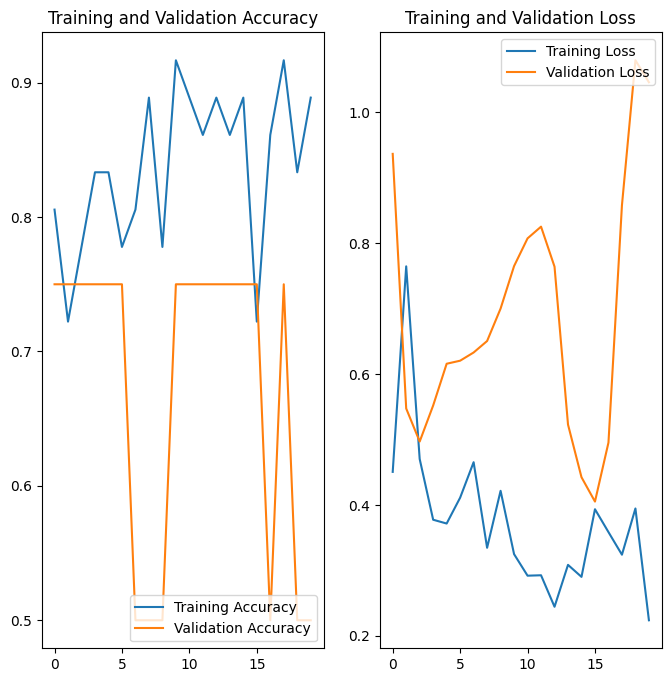

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()